In [2]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import imghdr
import seaborn as sns
from skimage.restoration import denoise_tv_chambolle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from tensorflow import keras
from PIL import Image
import torch
import warnings
warnings.filterwarnings("ignore")
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation


### Images Count

In [3]:
def display_count(image_dir, mask_dir):
    image_count = len(os.listdir(image_dir))
    mask_count = len(os.listdir(mask_dir))

    print(f"Number of images: {image_count}")
    print(f"Number of masks: {mask_count}")

# Directories containing images and masks
image_dir = '.\Dataset\Image'
mask_dir = '.\Dataset\Mask'

# Display the count of images and masks
display_count(image_dir, mask_dir)

Number of images: 289
Number of masks: 289


### Display Random Images and Its masks

In [4]:
def plot_images_and_masks(image_paths, mask_paths):
    # Plot image and mask side by side
    plt.figure(figsize=(18, 12))

    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(3, 2, 2*i + 1)
        plt.title('Original Image')
        plt.imshow(image_rgb)
        plt.axis('off')

        plt.subplot(3, 2, 2*i + 2)
        plt.title('Mask')
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

    plt.show()

In [5]:
def plot_overlay(image_paths, mask_paths):
    # Plot overlay of image and mask
    plt.figure(figsize=(18, 12))

    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        overlay = image_rgb.copy()
        overlay[mask > 0] = (255, 0, 0)  # Red color for the mask

        plt.subplot(3, 1, i + 1)
        plt.title('Overlay')
        plt.imshow(overlay)
        plt.axis('off')

    plt.show()

def get_random_image_mask_pairs(image_dir, mask_dir, num_pairs=3):
    image_files = os.listdir(image_dir)
    mask_files = os.listdir(mask_dir)

    image_mask_pairs = list(zip(image_files, mask_files))
    random_pairs = random.sample(image_mask_pairs, num_pairs)

    image_paths = [os.path.join(image_dir, pair[0]) for pair in random_pairs]
    mask_paths = [os.path.join(mask_dir, pair[1]) for pair in random_pairs]

    return image_paths, mask_paths


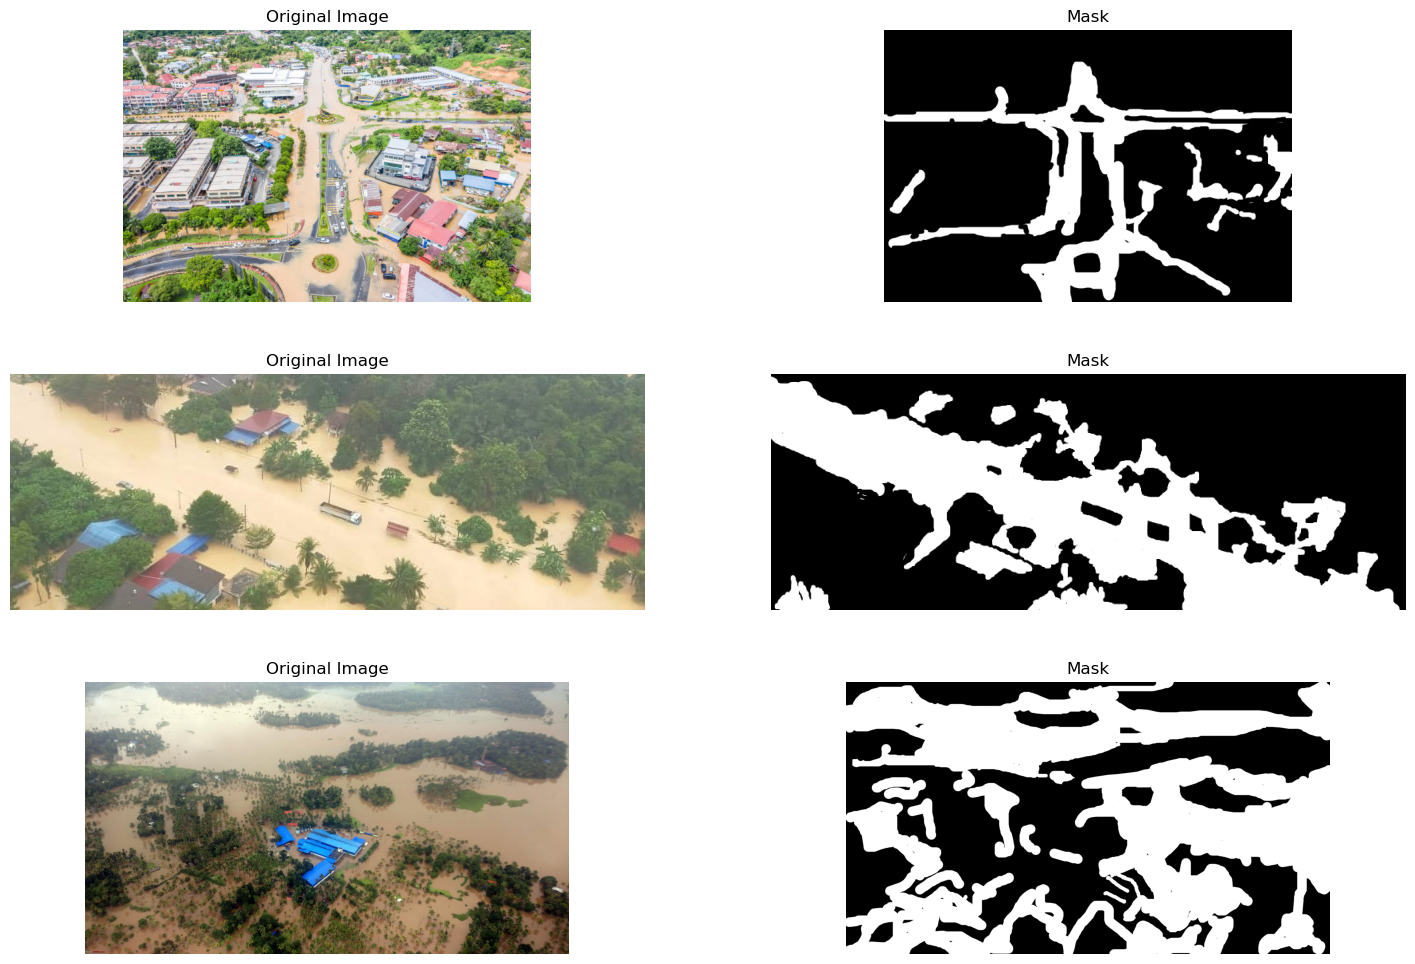

In [6]:
# Get random image-mask pairs
image_paths, mask_paths = get_random_image_mask_pairs(image_dir, mask_dir)

# Plot the images and masks
plot_images_and_masks(image_paths, mask_paths)


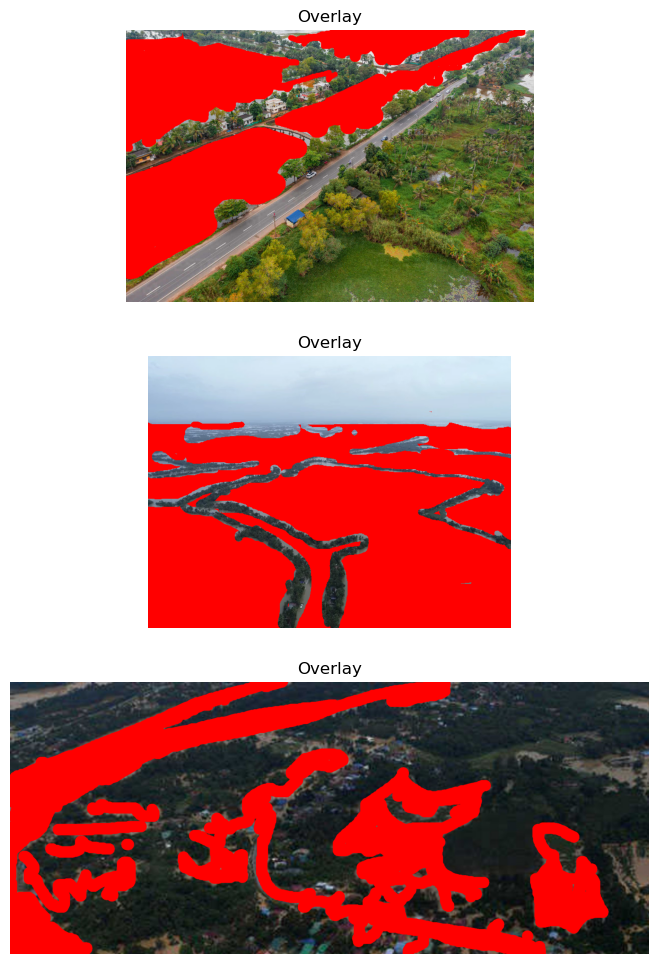

In [10]:
plot_overlay(image_paths, mask_paths)

### EDA to Display Images Dimensions and Mask Coverage

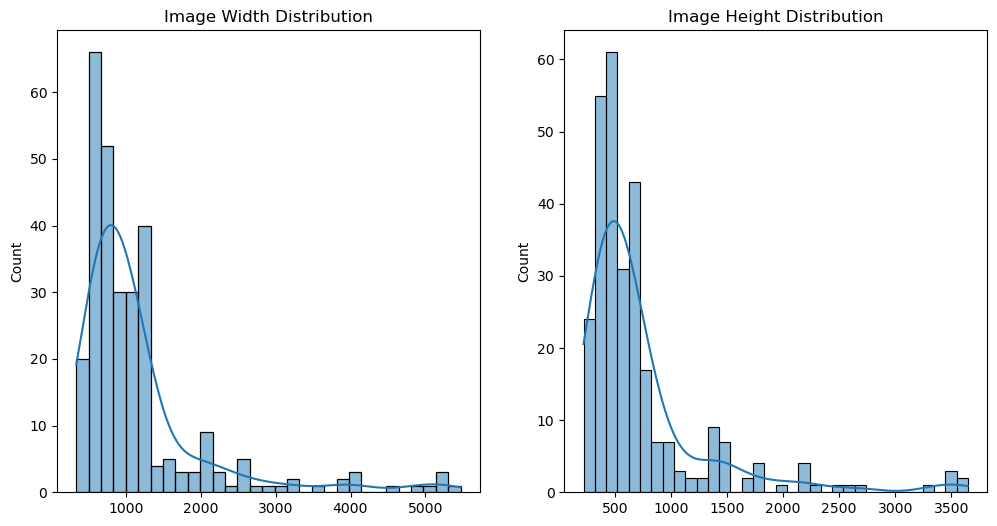

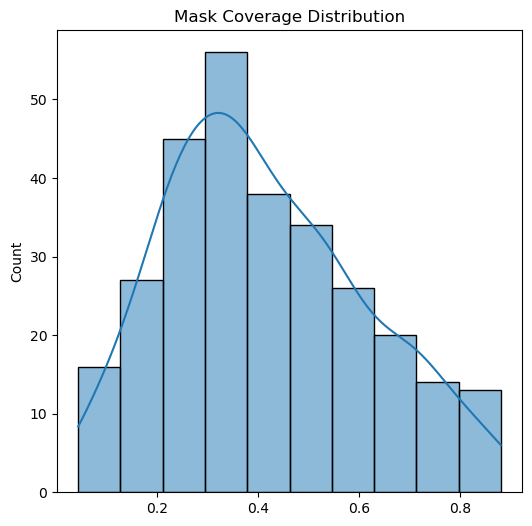

In [8]:
# Directories containing images and masks
image_dir = '.\\Dataset\\Image'
mask_dir = '.\\Dataset\\Mask'

# Get list of images and masks
image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)

# Initialize lists for image dimensions and mask coverage
image_dimensions = []
mask_coverage = []

# Analyze each image and mask
for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Error reading image: {image_path}")
        continue
    if mask is None:
        print(f"Error reading mask: {mask_path}")
        continue

    # Append image dimensions
    image_dimensions.append(image.shape[:2])

    # Calculate mask coverage
    mask_coverage.append(np.sum(mask > 0) / mask.size)

# Convert lists to arrays for easy analysis
image_dimensions = np.array(image_dimensions)
mask_coverage = np.array(mask_coverage)

# Plot image dimensions distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Image Width Distribution')
sns.histplot(image_dimensions[:, 1], kde=True)
plt.subplot(1, 2, 2)
plt.title('Image Height Distribution')
sns.histplot(image_dimensions[:, 0], kde=True)
plt.show()

# Plot mask coverage distribution
plt.figure(figsize=(6, 6))
plt.title('Mask Coverage Distribution')
sns.histplot(mask_coverage, kde=True)
plt.show()

### EDA: Distribution of Pixel intensity

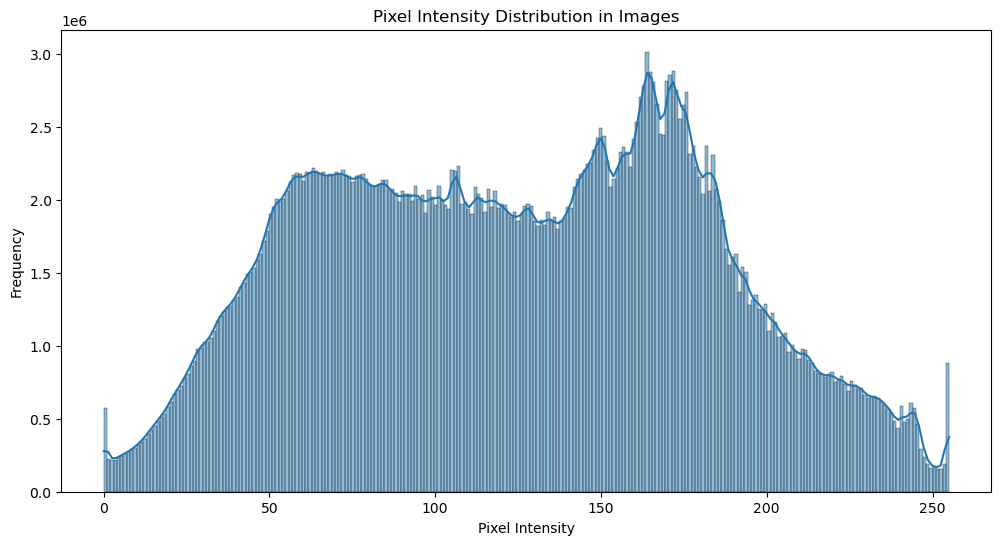

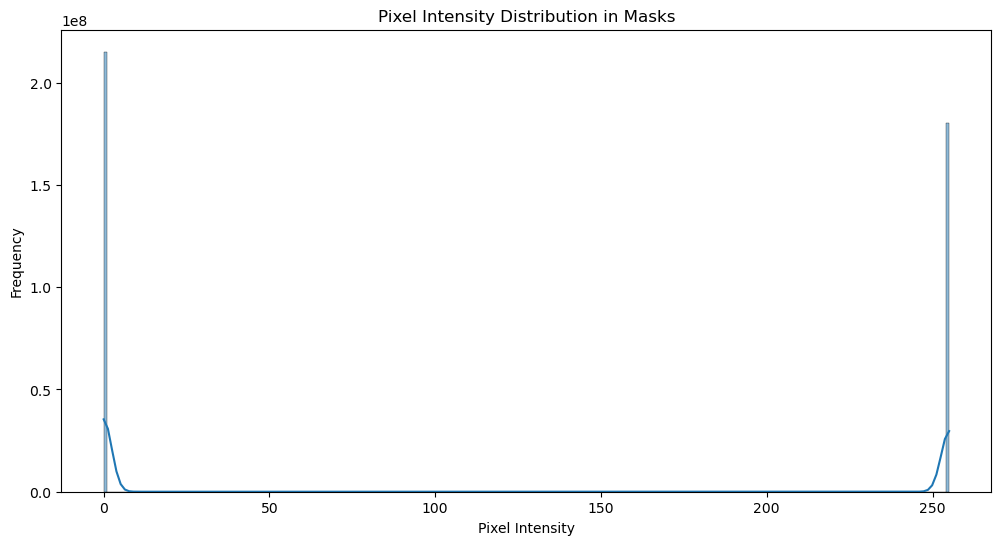

In [9]:
image_intensities = []
mask_intensities = []

# Analyze each image and mask
for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale for intensity analysis
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Error reading image: {image_path}")
        continue
    if mask is None:
        print(f"Error reading mask: {mask_path}")
        continue

    # Append pixel intensities
    image_intensities.extend(image.flatten())
    mask_intensities.extend(mask.flatten())

# Convert lists to arrays for easy analysis
image_intensities = np.array(image_intensities)
mask_intensities = np.array(mask_intensities)

# Plot pixel intensity distribution for images
plt.figure(figsize=(12, 6))
plt.title('Pixel Intensity Distribution in Images')
sns.histplot(image_intensities, bins=256, kde=True)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

# Plot pixel intensity distribution for masks
plt.figure(figsize=(12, 6))
plt.title('Pixel Intensity Distribution in Masks')
sns.histplot(mask_intensities, bins=256, kde=True)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

### Data Preprocessing: Total Variation Denoising